In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/vscode/.local/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Download block polygons with census data

In [ ]:
year = 2010
state_id = '14'
folder_name = 'censo_mza'
table_name = f'censo_mza_{year}'
query = f"SELECT * FROM {folder_name}.{table_name} WHERE \"CVEGEO\" LIKE \'{state_id}%%\'"
block_pop = aup.gdf_from_query(query, geometry_col='geometry')
print(block_pop.shape)
block_pop.head(2)

In [ ]:
block_pop = block_pop.to_crs("EPSG:6372")
block_pop.columns = block_pop.columns.str.lower()

In [ ]:
block_pop.plot()

## Generate "centroids" with census data

In [ ]:
block_pop = block_pop.set_index('cvegeo')
real_not_centroid = gpd.GeoDataFrame(geometry=block_pop.representative_point())
centroid_block_pop = real_not_centroid.merge(block_pop, right_index=True, left_index=True)
centroid_block_pop.drop(columns=['geometry_y'], inplace=True)
centroid_block_pop.rename(columns={'geometry_x':'geometry'}, inplace=True)
centroid_block_pop = gpd.GeoDataFrame(centroid_block_pop, geometry='geometry')
print(centroid_block_pop.shape)
centroid_block_pop.head(2)

#### Revision

In [ ]:
centroid_block_pop.pobtot.sum()

In [ ]:
block_pop.pobtot.sum()

## Centroid to hex

### Download state municipalities

In [ ]:
state_id = '14'
folder_name = 'marco'
table_name = 'mpos_2020'
query = f"SELECT * FROM {folder_name}.{table_name} WHERE \"CVEGEO\" LIKE \'{state_id}%%\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.head(2)

In [ ]:
mun_gdf = mun_gdf.dissolve()

In [ ]:
res = 8
hex_gdf_8 = aup.create_hexgrid(block_pop[['geometry']], res)
hex_gdf_8 = hex_gdf_8.set_crs("EPSG:4326")
print(hex_gdf_8.shape)
hex_gdf_8.head(2)

In [ ]:
res = 9
hex_gdf_9 = aup.create_hexgrid(mun_gdf, res)
hex_gdf_9 = hex_gdf_9.set_crs("EPSG:4326")
print(hex_gdf_9.shape)
hex_gdf_9.head(2)

### Group data

#### Delete filler columns

In [12]:
dlt_col = {2020:['cve_ent','cve_mun','cve_loc','cve_ageb',
           'cve_mza','ambito','tipomza','entidad',
           'nom_ent','mun','nom_mun','loc','ageb','mza'],
          2010:['codigo','geografico',
                'fechaact','geometria','institucio',
                'oid','entidad','nom_ent','mun','nom_mun',
                'loc','nom_loc','ageb','mza']}
centroid_block_pop.drop(columns=dlt_col[year], inplace=True)

In [13]:
centroid_block_pop = centroid_block_pop.to_crs("EPSG:4326")
centroid_block_pop = centroid_block_pop.reset_index()

In [14]:
string_columns = ['cvegeo']
avg_column = [
            "prom_hnv",
            "graproes",
            "graproes_f",
            "graproes_m",
            "prom_ocup",
            "pro_ocup_c",
        ]

wgt_dict = { "prom_hnv":'pobtot',
            "graproes":'pobtot',
            "graproes_f":'pobfem',
            "graproes_m":'pobmas',
            "prom_ocup":'tvivparhab',
            "pro_ocup_c":'tvivparhab'
           }

In [15]:
res = 8

hex_socio_df = aup.socio_points_to_polygon(
    hex_gdf_8,
    centroid_block_pop,
    f'hex_id_{res}',
    string_columns,
    wgt_dict=wgt_dict,
    avg_column=avg_column,
)
print(hex_socio_df.shape)
hex_socio_df.head(2)

(1176, 191)


,pobtot,pobmas,pobfem,p_0a2,p_0a2_m,p_0a2_f,p_3ymas,p_3ymas_m,p_3ymas_f,p_5ymas,...,vph_radio,vph_tv,vph_refri,vph_lavad,vph_autom,vph_pc,vph_telef,vph_cel,vph_inter,hex_id_8
0,4899.0,2416.0,2483.0,169.0,49.0,46.0,4626.0,2279.0,2347.0,4449.0,...,1162.0,1305.0,1264.0,1158.0,977.0,612.0,759.0,1124.0,507.0,88484a481dfffff
1,3484.0,1698.0,1770.0,225.0,88.0,89.0,3071.0,1493.0,1576.0,2863.0,...,815.0,967.0,968.0,903.0,907.0,671.0,623.0,929.0,570.0,88485bb2d7fffff


In [16]:
hex_socio_df.pobtot.sum()

2893127.0

In [19]:
hex_gdf_socio = hex_gdf_9.merge(hex_socio_df, on=f'hex_id_{res}')
hex_gdf_socio.head(2)

,hex_id_9,geometry,nom_loc,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic
0,894988d9347ffff,"POLYGON ((-102.32849 21.90442, -102.32725 21.9...",AguascalientesAguascalientesAguascalientes,101.0,48.0,53.0,4.0,3.0,0.0,96.0,...,21.0,32.0,32.0,21.0,26.0,14.0,0.0,0.0,0.0,0.0
1,89498e22b93ffff,"POLYGON ((-102.14663 22.01696, -102.14538 22.0...",JaltomateJaltomate,131.0,72.0,59.0,7.0,4.0,3.0,124.0,...,0.0,30.0,11.0,10.0,0.0,3.0,0.0,0.0,21.0,0.0


In [20]:
hex_gdf_socio['dens_pob_ha'] = hex_gdf_socio.pobtot / (hex_gdf_socio.to_crs("EPSG:6372").area)

<AxesSubplot:>

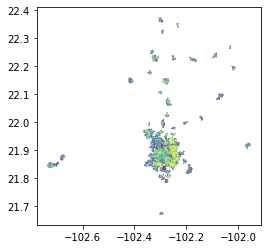

In [23]:
hex_gdf_socio.plot('dens_pob_ha', 'viridis')

# V2

In [2]:
df = pd.read_json("../scripts/Metropolis_CVE.json")

year = 2020

#Folder names from database
block_schema = 'censo_mza'
block_folder = f'censo_mza_{year}'
mpos_schema = 'marco'
mpos_folder = f'mpos_{year}'

c = 'Guadalajara'
# Creates empty GeoDataFrame to store specified municipality polygons, infonavit_grid and hexbins
mun_gdf = gpd.GeoDataFrame()
block_pop = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
for i in range(len(df.loc["mpos", c])):
    # Extracts specific municipality code
    m = df.loc["mpos", c][i]
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {mpos_schema}.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    #Creates query to download block data
    query = f"SELECT * FROM {block_schema}.{block_folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    block_pop = block_pop.append(aup.gdf_from_query(query, geometry_col='geometry'))
    aup.log(f"Donwloaded hex bins for {m}")

In [3]:
print(mun_gdf.shape)
mun_gdf.head(2)

(10, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,14002,14,002,Acatlán de Juárez,"POLYGON ((-103.65448 20.50346, -103.65200 20.5..."
0,14039,14,039,Guadalajara,"POLYGON ((-103.31164 20.75098, -103.31014 20.7..."


In [4]:
print(block_pop.shape)
block_pop.head(2)

(56645, 239)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry,ENTIDAD,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,1400200020153003,14,002,0002,0153,003,Urbana,Típica,"POLYGON ((-103.63950 20.43061, -103.63983 20.4...",14,...,3,18,9,12,3,None,0,None,9,0
1,1400200020257002,14,002,0002,0257,002,Urbana,Típica,"POLYGON ((-103.64007 20.42947, -103.64014 20.4...",14,...,None,None,None,None,None,None,None,None,None,None


In [5]:
block_pop = block_pop.to_crs("EPSG:6372")
block_pop.columns = block_pop.columns.str.lower()

<AxesSubplot:>

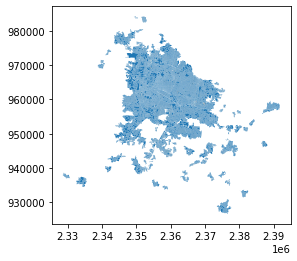

In [6]:
block_pop.plot()

In [7]:
block_pop = block_pop.set_index('cvegeo')
real_not_centroid = gpd.GeoDataFrame(geometry=block_pop.representative_point())
centroid_block_pop = real_not_centroid.merge(block_pop, right_index=True, left_index=True)
centroid_block_pop.drop(columns=['geometry_y'], inplace=True)
centroid_block_pop.rename(columns={'geometry_x':'geometry'}, inplace=True)
centroid_block_pop = gpd.GeoDataFrame(centroid_block_pop, geometry='geometry')
print(centroid_block_pop.shape)
centroid_block_pop.head(2)

(56645, 238)


,geometry,cve_ent,cve_mun,cve_loc,cve_ageb,cve_mza,ambito,tipomza,entidad,nom_ent,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sinltc,vph_sincint,vph_sintic
cvegeo,,,,,,,,,,,,,,,,,,,,,
1400200020153003,POINT (2329566.217 937214.733),14,002,0002,0153,003,Urbana,Típica,14,Jalisco,...,3,18,9,12,3,None,0,None,9,0
1400200020257002,POINT (2329541.384 937061.583),14,002,0002,0257,002,Urbana,Típica,14,Jalisco,...,None,None,None,None,None,None,None,None,None,None


In [8]:
centroid_block_pop.pobtot.sum()

5120219

In [9]:
block_pop.pobtot.sum()

5120219

In [10]:
res = 8
hex_gdf_8 = aup.create_hexgrid(mun_gdf, res)
hex_gdf_8 = hex_gdf_8.set_crs("EPSG:4326")
print(hex_gdf_8.shape)
hex_gdf_8.head(2)

(4095, 2)


,hex_id_8,geometry
0,8849aa268bfffff,"POLYGON ((-103.56573 20.43790, -103.56120 20.4..."
1,8849ab5359fffff,"POLYGON ((-103.62267 20.47169, -103.61814 20.4..."


In [11]:
dlt_col = {2020:['cve_ent','cve_mun','cve_loc','cve_ageb',
           'cve_mza','ambito','tipomza','entidad',
           'nom_ent','mun','nom_mun','loc','ageb','mza'],
          2010:['codigo','geografico',
                'fechaact','geometria','institucio',
                'oid','entidad','nom_ent','mun','nom_mun',
                'loc','nom_loc','ageb','mza']}
centroid_block_pop.drop(columns=dlt_col[year], inplace=True)

In [12]:
centroid_block_pop = centroid_block_pop.to_crs("EPSG:4326")
centroid_block_pop = centroid_block_pop.reset_index()

In [18]:
string_columns = ['cvegeo']
avg_column = [
            "prom_hnv",
            "graproes",
            "graproes_f",
            "graproes_m",
            "prom_ocup",
            "pro_ocup_c",
        ]

wgt_dict = { "prom_hnv":'pobtot',
            "graproes":'pobtot',
            "graproes_f":'pobfem',
            "graproes_m":'pobmas',
            "prom_ocup":'tvivparhab',
            "pro_ocup_c":'tvivparhab'
           }

In [ ]:
res = 8

hex_socio_df = aup.socio_points_to_polygon(
    hex_gdf_8,
    centroid_block_pop,
    f'hex_id_{res}',
    string_columns,
    wgt_dict=wgt_dict,
    avg_column=avg_column,
)
print(hex_socio_df.shape)
hex_socio_df.head(2)

In [ ]:
hex_socio_df.pobtot.sum()